In [1]:
from nba_api.stats.static import players, teams
from nba_api.stats.endpoints import playercareerstats, leagueleaders
import pandas as pd
import numpy as np
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score

In [2]:
def get_defensive_leaders(season):
    """Get defensive statistics for potential DPOY candidates for a given season"""
    # Get blocks leaders
    blocks = leagueleaders.LeagueLeaders(
        season=season,
        stat_category_abbreviation='BLK',
        per_mode48='PerGame'
    ).get_data_frames()[0]
    
    # Get steals leaders
    steals = leagueleaders.LeagueLeaders(
        season=season,
        stat_category_abbreviation='STL',
        per_mode48='PerGame'
    ).get_data_frames()[0]
    
    # Get defensive rebounds leaders
    def_reb = leagueleaders.LeagueLeaders(
        season=season,
        stat_category_abbreviation='DREB',
        per_mode48='PerGame'
    ).get_data_frames()[0]
    
    # Combine and process the data
    blocks = blocks[['PLAYER', 'TEAM', 'GP', 'MIN', 'BLK', 'DREB', 'STL']].head(15)
    steals = steals[['PLAYER', 'TEAM', 'GP', 'MIN', 'BLK', 'DREB', 'STL']].head(15)
    def_reb = def_reb[['PLAYER', 'TEAM', 'GP', 'MIN', 'BLK', 'DREB', 'STL']].head(15)
    
    # Combine all leaders and remove duplicates
    all_defenders = pd.concat([blocks, steals, def_reb]).drop_duplicates(subset=['PLAYER'])
    
    #Gave block and steal a weight of 2
    all_defenders['DEF_SCORE'] = (
        all_defenders['BLK'] * 2 + 
        all_defenders['STL'] * 2 + 
        all_defenders['DREB'] * 0.5
    )
    
    return all_defenders.sort_values('DEF_SCORE', ascending=False).head(10)

def get_last_20_seasons():
    """Calculate the last 20 seasons range"""
    current_year = datetime.now().year
    if datetime.now().month < 10:
        current_year -= 1
    start_year = current_year - 19  # 20 seasons including the current/last season
    return start_year, current_year

def get_historical_dpoy_candidates():
    """Get defensive leaders for the last 20 seasons"""
    start_year, end_year = get_last_20_seasons()
    all_seasons = []
    
    for year in range(start_year, end_year + 1):
        season = f"{year}-{str(year+1)[-2:]}"
        try:
            season_data = get_defensive_leaders(season)
            season_data['SEASON'] = season
            all_seasons.append(season_data)
            print(f"Processed season {season}")
        except Exception as e:
            print(f"Error processing season {season}: {e}")
    
    return pd.concat(all_seasons)

if __name__ == "__main__":
    start_year, end_year = get_last_20_seasons()
    print(f"\nFetching defensive stats from {start_year}-{start_year+1} to {end_year}-{end_year+1}")
    
    # Get defenders for the last 20 seasons
    historical_defenders = get_historical_dpoy_candidates()
    
    # Display results sorted by season and defensive score
    print("\nTop Defensive Players by Season:")
    display_cols = ['SEASON', 'PLAYER', 'TEAM', 'GP', 'MIN', 'BLK', 'STL', 'DREB', 'DEF_SCORE']
    print(historical_defenders[display_cols].sort_values(['SEASON', 'DEF_SCORE'], ascending=[False, False]))


Fetching defensive stats from 2005-2006 to 2024-2025
Processed season 2005-06
Processed season 2006-07
Processed season 2007-08
Processed season 2008-09
Processed season 2009-10
Processed season 2010-11
Processed season 2011-12
Processed season 2012-13
Processed season 2013-14
Processed season 2014-15
Processed season 2015-16
Processed season 2016-17
Processed season 2017-18
Processed season 2018-19
Processed season 2019-20
Processed season 2020-21
Processed season 2021-22
Processed season 2022-23
Processed season 2023-24
Processed season 2024-25

Top Defensive Players by Season:
     SEASON             PLAYER TEAM  GP   MIN  BLK  STL  DREB  DEF_SCORE
0   2024-25  Victor Wembanyama  SAS  21  32.3  3.5  1.1   8.3      13.35
5   2024-25      Anthony Davis  LAL  25  35.3  2.0  1.2   8.9      10.85
1   2024-25     Walker Kessler  UTA  19  29.1  2.8  0.5   6.6       9.90
6   2024-25       Nikola Jokić  DEN  21  37.3  0.7  1.8   9.5       9.75
0   2024-25      Dyson Daniels  ATL  25  34.0  

In [61]:
# Historical DPOY top 3 finishers for the last 20 seasons
dpoy_nominees = {
    '2023-24': ['Rudy Gobert', 'Bam Adebayo', 'Victor Wembanyama'],
    '2022-23': ['Jaren Jackson Jr.', 'Brook Lopez', 'Evan Mobley'],
    '2021-22': ['Marcus Smart', 'Mikal Bridges', 'Rudy Gobert'],
    '2020-21': ['Rudy Gobert', 'Ben Simmons', 'Draymond Green'],
    '2019-20': ['Giannis Antetokounmpo', 'Anthony Davis', 'Rudy Gobert'],
    '2018-19': ['Rudy Gobert', 'Paul George', 'Giannis Antetokounmpo'],
    '2017-18': ['Rudy Gobert', 'Joel Embiid', 'Anthony Davis'],
    '2016-17': ['Draymond Green', 'Rudy Gobert', 'Kawhi Leonard'],
    '2015-16': ['Kawhi Leonard', 'Draymond Green', 'Hassan Whiteside'],
    '2014-15': ['Kawhi Leonard', 'Draymond Green', 'DeAndre Jordan'],
    '2013-14': ['Joakim Noah', 'Roy Hibbert', 'DeAndre Jordan'],
    '2012-13': ['Marc Gasol', 'LeBron James', 'Serge Ibaka'],
    '2011-12': ['Tyson Chandler', 'Serge Ibaka', 'Dwight Howard'],
    '2010-11': ['Dwight Howard', 'Kevin Garnett', 'Tyson Chandler'],
    '2009-10': ['Dwight Howard', 'Josh Smith', 'Gerald Wallace'],
    '2008-09': ['Dwight Howard', 'LeBron James', 'Chris Paul'],
    '2007-08': ['Kevin Garnett', 'Marcus Camby', 'Bruce Bowen'],
    '2006-07': ['Marcus Camby', 'Bruce Bowen', 'Tim Duncan'],
    '2005-06': ['Ben Wallace', 'Bruce Bowen', 'Ron Artest'],
    '2004-05': ['Ben Wallace', 'Marcus Camby', 'Kevin Garnett']
}

def get_season_stats(season):
    """Get defensive statistics for all players in a season"""
    try:
        # Get top 100 players in each statline
        blocks = leagueleaders.LeagueLeaders(
            season=season,
            stat_category_abbreviation='BLK',
            per_mode48='PerGame'
        ).get_data_frames()[0]
        
        steals = leagueleaders.LeagueLeaders(
            season=season,
            stat_category_abbreviation='STL',
            per_mode48='PerGame'
        ).get_data_frames()[0]
        
        def_reb = leagueleaders.LeagueLeaders(
            season=season,
            stat_category_abbreviation='DREB',
            per_mode48='PerGame'
        ).get_data_frames()[0]
        
        # Combine stats and remove duplicates
        all_players = pd.concat([
            blocks[['PLAYER', 'TEAM', 'GP', 'MIN', 'BLK', 'DREB', 'STL']],
            steals[['PLAYER', 'TEAM', 'GP', 'MIN', 'BLK', 'DREB', 'STL']],
            def_reb[['PLAYER', 'TEAM', 'GP', 'MIN', 'BLK', 'DREB', 'STL']]
        ]).drop_duplicates(subset=['PLAYER'])
        
        # Add nomination status
        all_players['IS_NOMINEE'] = all_players['PLAYER'].isin(dpoy_nominees[season]).astype(int)
        
        return all_players
    
    except Exception as e:
        print(f"Error getting stats for season {season}: {e}")
        return None

def analyze_nomination_correlations():
    """Analyze correlations between defensive stats and DPOY nomination"""
    all_seasons = []
    
    for season in dpoy_nominees.keys():
        season_data = get_season_stats(season)
        if season_data is not None:
            # Calculate per-36 minute stats
            for stat in ['BLK', 'STL', 'DREB']:
                season_data[f'{stat}_PER_36'] = season_data[stat] * 36 / season_data['MIN']
            
            season_data['SEASON'] = season
            all_seasons.append(season_data)
            print(f"Processed season {season}")
    
    # Combine all seasons
    df = pd.DataFrame(pd.concat(all_seasons))
    
    # Calculate correlations
    stats_cols = ['BLK', 'STL', 'DREB', 'GP', 'MIN', 
                 'BLK_PER_36', 'STL_PER_36', 'DREB_PER_36']
    
    correlations = df[stats_cols + ['IS_NOMINEE']].corr()['IS_NOMINEE'].drop('IS_NOMINEE')
    
    return df, correlations

if __name__ == "__main__":
    df, correlations = analyze_nomination_correlations()
    
    print("\nCorrelations with DPOY Nomination:")
    for stat, score in correlations.abs().sort_values(ascending=False).items():
        print(f"{stat}: {score:.3f}")
    
    # Compare average stats between nominees and non-nominees
    print("\nAverage Stats Comparison:")
    stats = ['BLK', 'STL', 'DREB', 'GP', 'MIN', 
            'BLK_PER_36', 'STL_PER_36', 'DREB_PER_36']
    
    comparison = df.groupby('IS_NOMINEE')[stats].mean()
    print(comparison)

Processed season 2023-24
Processed season 2022-23
Processed season 2021-22
Processed season 2020-21
Processed season 2019-20
Processed season 2018-19
Processed season 2017-18
Processed season 2016-17
Processed season 2015-16
Processed season 2014-15
Processed season 2013-14
Processed season 2012-13
Processed season 2011-12
Processed season 2010-11
Processed season 2009-10
Processed season 2008-09
Processed season 2007-08
Processed season 2006-07
Processed season 2005-06
Processed season 2004-05

Correlations with DPOY Nomination:
BLK: 0.282
DREB: 0.240
BLK_PER_36: 0.198
DREB_PER_36: 0.178
MIN: 0.117
STL: 0.109
STL_PER_36: 0.043
GP: 0.031

Average Stats Comparison:
                 BLK       STL      DREB         GP        MIN  BLK_PER_36  \
IS_NOMINEE                                                                   
0           0.516957  0.815916  3.487435  72.039620  26.075979    0.738801   
1           1.784483  1.200000  7.322414  74.172414  33.418966    1.955468   

            ST

Processed season 2023-24
Processed season 2022-23
Processed season 2021-22
Processed season 2020-21
Processed season 2019-20
Processed season 2018-19
Processed season 2017-18
Processed season 2016-17
Processed season 2015-16
Processed season 2014-15
Processed season 2013-14
Processed season 2012-13
Processed season 2011-12
Processed season 2010-11
Processed season 2009-10
Processed season 2008-09
Processed season 2007-08
Processed season 2006-07
Processed season 2005-06
Processed season 2004-05


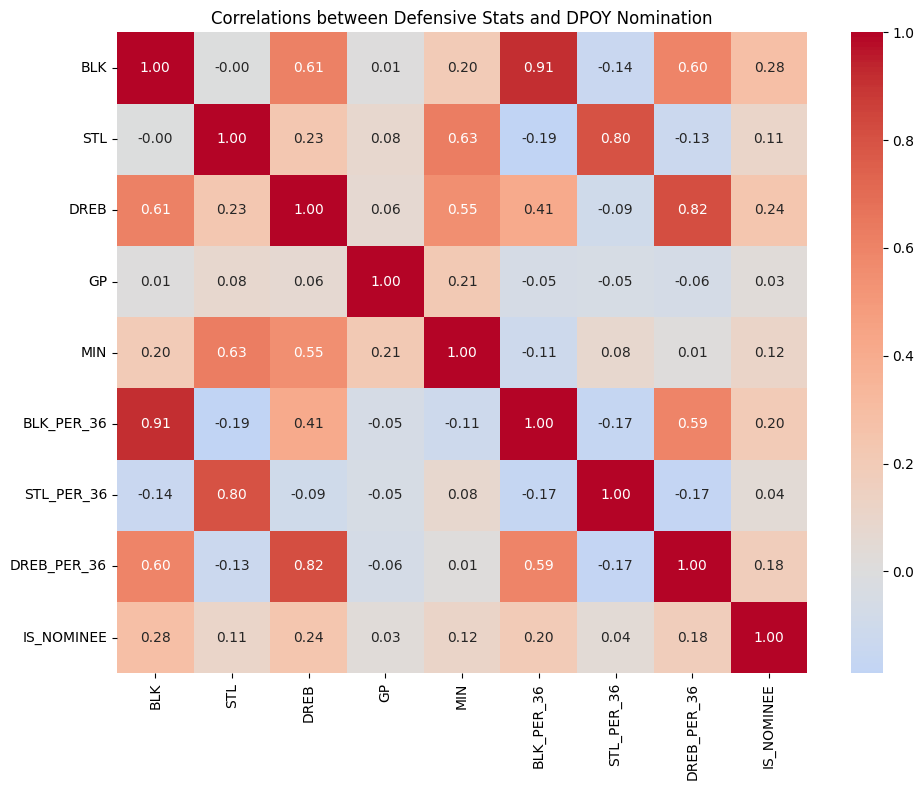

In [62]:
#Get Data
df, correlations = analyze_nomination_correlations()

# Create correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(df[['BLK', 'STL', 'DREB', 'GP', 'MIN', 
                'BLK_PER_36', 'STL_PER_36', 'DREB_PER_36', 'IS_NOMINEE']].corr(), 
            annot=True,  # Show correlation values
            cmap='coolwarm',  # Blue-red diverging colormap
            center=0,  # Center the colormap at 0
            fmt='.2f')  # Show 2 decimal places
plt.title('Correlations between Defensive Stats and DPOY Nomination')
plt.tight_layout()
plt.show()

Processed season 2023-24
Processed season 2022-23
Processed season 2021-22
Processed season 2020-21
Processed season 2019-20
Processed season 2018-19
Processed season 2017-18
Processed season 2016-17
Processed season 2015-16
Processed season 2014-15
Processed season 2013-14
Processed season 2012-13
Processed season 2011-12
Processed season 2010-11
Processed season 2009-10
Processed season 2008-09
Processed season 2007-08
Processed season 2006-07
Processed season 2005-06
Processed season 2004-05


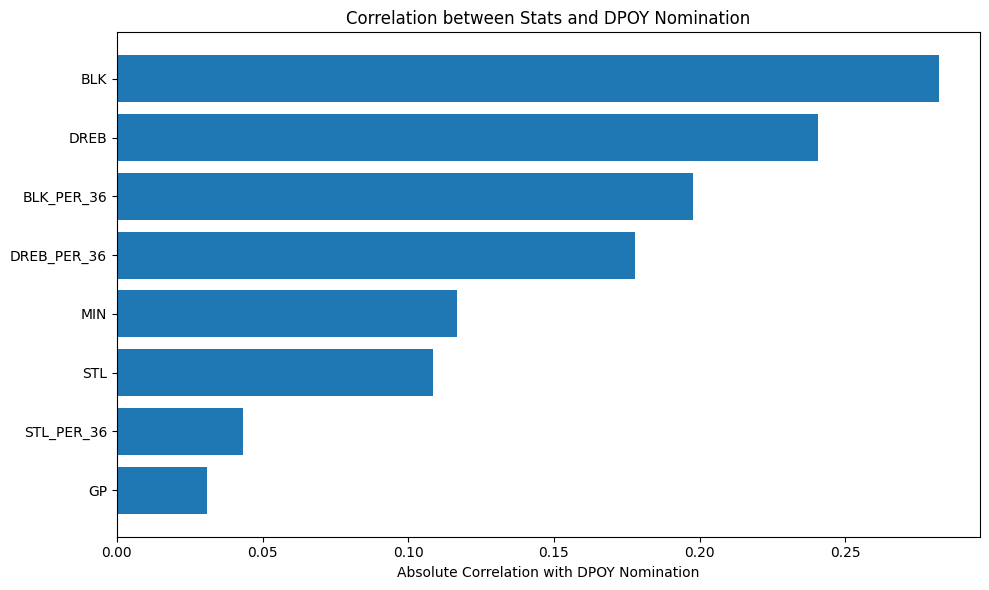

In [63]:
# Get data
df, correlations = analyze_nomination_correlations()

# Create bar plot
plt.figure(figsize=(10, 6))
corr_sorted = correlations.abs().sort_values(ascending=True)
plt.barh(range(len(corr_sorted)), corr_sorted.values)
plt.yticks(range(len(corr_sorted)), corr_sorted.index)
plt.xlabel('Absolute Correlation with DPOY Nomination')
plt.title('Correlation between Stats and DPOY Nomination')
plt.tight_layout()
plt.show()

In [64]:
FEATURES = ['BLK', 'STL', 'DREB', 'GP', 'MIN', 
           'BLK_PER_36', 'STL_PER_36', 'DREB_PER_36', 'DEF_SCORE']

# Historical DPOY nominees dictionary for validation
actual_nominees = {
    '2023-24': ['Rudy Gobert', 'Bam Adebayo', 'Victor Wembanyama'],
    '2022-23': ['Jaren Jackson Jr.', 'Brook Lopez', 'Evan Mobley'],
    '2021-22': ['Marcus Smart', 'Mikal Bridges', 'Rudy Gobert'],
    '2020-21': ['Rudy Gobert', 'Ben Simmons', 'Draymond Green'],
    '2019-20': ['Giannis Antetokounmpo', 'Anthony Davis', 'Rudy Gobert'],
    '2018-19': ['Rudy Gobert', 'Paul George', 'Giannis Antetokounmpo'],
    '2017-18': ['Rudy Gobert', 'Joel Embiid', 'Anthony Davis'],
    '2016-17': ['Draymond Green', 'Rudy Gobert', 'Kawhi Leonard'],
    '2015-16': ['Kawhi Leonard', 'Draymond Green', 'Hassan Whiteside'],
    '2014-15': ['Kawhi Leonard', 'Draymond Green', 'DeAndre Jordan']
}

def get_season_data(season):
    blocks = leagueleaders.LeagueLeaders(
        season=season,
        stat_category_abbreviation='BLK',
        per_mode48='PerGame'
    ).get_data_frames()[0]
    
    steals = leagueleaders.LeagueLeaders(
        season=season,
        stat_category_abbreviation='STL',
        per_mode48='PerGame'
    ).get_data_frames()[0]
    
    def_reb = leagueleaders.LeagueLeaders(
        season=season,
        stat_category_abbreviation='DREB',
        per_mode48='PerGame'
    ).get_data_frames()[0]
    
    blocks = blocks[['PLAYER', 'TEAM', 'GP', 'MIN', 'BLK', 'DREB', 'STL']].head(50)
    steals = steals[['PLAYER', 'TEAM', 'GP', 'MIN', 'BLK', 'DREB', 'STL']].head(50)
    def_reb = def_reb[['PLAYER', 'TEAM', 'GP', 'MIN', 'BLK', 'DREB', 'STL']].head(50)
    
    all_players = pd.concat([blocks, steals, def_reb]).drop_duplicates(subset=['PLAYER'])
    
    # Calculate per-36 minute stats and defensive score
    for stat in ['BLK', 'STL', 'DREB']:
        all_players[f'{stat}_PER_36'] = all_players[stat] * 36 / all_players['MIN']
    
    all_players['DEF_SCORE'] = (
        all_players['BLK'] * 2 + 
        all_players['STL'] * 2 + 
        all_players['DREB'] * 0.5
    ) * (all_players['GP'] / 82)
    
    # Add actual nominee information
    all_players['ACTUAL_NOMINEE'] = all_players['PLAYER'].isin(actual_nominees.get(season, []))
    
    return all_players

def evaluate_random_forest_model():
    all_seasons_data = []
    
    print("Gathering data and training Random Forest model:")
    
    # Process each season
    for season in actual_nominees.keys():
        season_data = get_season_data(season)
        season_data['SEASON'] = season
        all_seasons_data.append(season_data)
        
    # Combine all seasons
    full_data = pd.concat(all_seasons_data)
    
    X = full_data[FEATURES]
    y = full_data['ACTUAL_NOMINEE']
    
    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Train Random Forest model
    rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
    rf_model.fit(X_train, y_train)
    
    # Print model performance
    print("\nModel Performance Metrics:")
    print(f"Training Accuracy: {rf_model.score(X_train, y_train):.3f}")
    print(f"Test Accuracy: {rf_model.score(X_test, y_test):.3f}")
    
    # Feature importance
    feature_importance = pd.DataFrame({
        'Feature': FEATURES,
        'Importance': rf_model.feature_importances_
    }).sort_values('Importance', ascending=False)
    
    print("\nFeature Importance:")
    print(feature_importance)
    
    #Predictions for each season
    for season in actual_nominees.keys():
        season_data = full_data[full_data['SEASON'] == season].copy()
        X_season = season_data[FEATURES]
        
        # Get predictions
        probabilities = rf_model.predict_proba(X_season)[:, 1]
        season_data['PREDICTED_PROBABILITY'] = probabilities
        
        # Get top 3 predicted nominees
        predicted_nominees = season_data.nlargest(3, 'PREDICTED_PROBABILITY')
        actual_season_nominees = actual_nominees[season]
        
        # Calculate accuracy for this season
        correct_predictions = len(set(predicted_nominees['PLAYER']).intersection(actual_season_nominees))
        
        print(f"\n{season} Season:")
        print("Actual Nominees:", actual_season_nominees)
        print("Model's Top 3 Predictions:")
        for _, player in predicted_nominees.iterrows():
            print(f"{player['PLAYER']}: {player['PREDICTED_PROBABILITY']:.3f} (DEF_SCORE: {player['DEF_SCORE']:.2f})")
        print(f"Correctly Predicted: {correct_predictions}/3")

    return rf_model, full_data

# Run evaluation
rf_model, full_data = evaluate_random_forest_model()

Gathering data and training Random Forest model:

Model Performance Metrics:
Training Accuracy: 1.000
Test Accuracy: 0.953

Feature Importance:
       Feature  Importance
8    DEF_SCORE    0.207615
0          BLK    0.131129
2         DREB    0.119485
7  DREB_PER_36    0.116153
5   BLK_PER_36    0.106499
1          STL    0.104958
6   STL_PER_36    0.085679
4          MIN    0.072326
3           GP    0.056155

2023-24 Season:
Actual Nominees: ['Rudy Gobert', 'Bam Adebayo', 'Victor Wembanyama']
Model's Top 3 Predictions:
Victor Wembanyama: 0.840 (DEF_SCORE: 11.95)
Rudy Gobert: 0.670 (DEF_SCORE: 9.45)
Anthony Davis: 0.590 (DEF_SCORE: 10.89)
Correctly Predicted: 2/3

2022-23 Season:
Actual Nominees: ['Jaren Jackson Jr.', 'Brook Lopez', 'Evan Mobley']
Model's Top 3 Predictions:
Evan Mobley: 0.600 (DEF_SCORE: 7.61)
Brook Lopez: 0.520 (DEF_SCORE: 7.94)
Nic Claxton: 0.420 (DEF_SCORE: 9.45)
Correctly Predicted: 2/3

2021-22 Season:
Actual Nominees: ['Marcus Smart', 'Mikal Bridges', 'Rudy Gobe

In [65]:
print(f"Total rows in full_data: {len(full_data)}")
print(full_data.head())


Total rows in full_data: 1066
              PLAYER TEAM  GP   MIN  BLK  DREB  STL  BLK_PER_36  STL_PER_36  \
0  Victor Wembanyama  SAS  71  29.7  3.6   8.4  1.2    4.363636    1.454545   
1     Walker Kessler  UTA  64  23.3  2.4   4.9  0.5    3.708155    0.772532   
2        Brook Lopez  MIL  79  30.5  2.4   3.7  0.5    2.832787    0.590164   
3      Anthony Davis  LAL  76  35.5  2.3   9.5  1.2    2.332394    1.216901   
4      Chet Holmgren  OKC  82  29.4  2.3   6.3  0.6    2.816327    0.734694   

   DREB_PER_36  DEF_SCORE  ACTUAL_NOMINEE   SEASON  
0    10.181818  11.948780            True  2023-24  
1     7.570815   6.439024           False  2023-24  
2     4.367213   7.370122           False  2023-24  
3     9.633803  10.890244           False  2023-24  
4     7.714286   8.950000           False  2023-24  


In [71]:
def create_defensive_first_team(data):
   
    positions = ['G', 'G', 'F', 'F', 'C']
    data['POSITION'] = np.random.choice(positions, len(data), replace=True)
    
    data_sorted = data.sort_values('DEF_SCORE', ascending=False)
    
    first_team = pd.DataFrame()
    for position in ['G', 'F', 'C']:
        
        if position == 'C':
            top_players = data_sorted[data_sorted['POSITION'] == position].head(1)
        else:
            top_players = data_sorted[data_sorted['POSITION'] == position].head(2)
        first_team = pd.concat([first_team, top_players])
    
   
    return first_team

if __name__ == "__main__":
    print("\nDefensive First Team:")
    defensive_first_team = create_defensive_first_team(full_data)
    display_cols = ['PLAYER', 'TEAM', 'POSITION', 'GP', 'MIN', 'BLK', 'STL', 'DREB', 'DEF_SCORE']
    print(defensive_first_team[display_cols].sort_values('DEF_SCORE', ascending=False))



Defensive First Team:
              PLAYER TEAM POSITION  GP   MIN  BLK  STL  DREB  DEF_SCORE
0  Victor Wembanyama  SAS        C  71  29.7  3.6  1.2   8.4  11.948780
0   Hassan Whiteside  MIA        F  73  29.1  3.7  0.6   8.6  11.484146
7     Andre Drummond  DET        G  79  33.5  1.7  1.7  10.2  11.464634
3     DeAndre Jordan  LAC        F  82  34.4  2.2  1.0  10.1  11.450000
1      Anthony Davis  NOP        G  75  36.1  2.2  1.3   9.5  10.746951


In [68]:
print(full_data[['PLAYER', 'POSITION']].drop_duplicates().head(10))


              PLAYER POSITION
0  Victor Wembanyama  Unknown
1     Walker Kessler  Unknown
2        Brook Lopez  Unknown
3      Anthony Davis  Unknown
4      Chet Holmgren  Unknown
5        Rudy Gobert  Unknown
6     Daniel Gafford  Unknown
7        Nic Claxton  Unknown
8       Myles Turner  Unknown
9  Jaren Jackson Jr.  Unknown


### WORK IN PROGRESS ###

In [ ]:
#######WORK IN PROGRESS
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd
from nba_api.stats.endpoints import leagueleaders

# Features to use for training
FEATURES = ['BLK', 'STL', 'DREB', 'GP', 'MIN', 
           'BLK_PER_36', 'STL_PER_36', 'DREB_PER_36', 'DEF_SCORE']

# Historical nominees for validation
actual_nominees = {
    '2023-24': ['Rudy Gobert', 'Bam Adebayo', 'Victor Wembanyama'],
    '2022-23': ['Jaren Jackson Jr.', 'Brook Lopez', 'Evan Mobley'],
    '2021-22': ['Marcus Smart', 'Mikal Bridges', 'Rudy Gobert'],
    '2020-21': ['Rudy Gobert', 'Ben Simmons', 'Draymond Green'],
    '2019-20': ['Giannis Antetokounmpo', 'Anthony Davis', 'Rudy Gobert'],
    '2018-19': ['Rudy Gobert', 'Paul George', 'Giannis Antetokounmpo'],
    '2017-18': ['Rudy Gobert', 'Joel Embiid', 'Anthony Davis'],
    '2016-17': ['Draymond Green', 'Rudy Gobert', 'Kawhi Leonard'],
    '2015-16': ['Kawhi Leonard', 'Draymond Green', 'Hassan Whiteside'],
    '2014-15': ['Kawhi Leonard', 'Draymond Green', 'DeAndre Jordan']
}

# Function to collect and process data for a season
def get_season_data(season):
    blocks = leagueleaders.LeagueLeaders(
        season=season,
        stat_category_abbreviation='BLK',
        per_mode48='PerGame'
    ).get_data_frames()[0]
    
    steals = leagueleaders.LeagueLeaders(
        season=season,
        stat_category_abbreviation='STL',
        per_mode48='PerGame'
    ).get_data_frames()[0]
    
    def_reb = leagueleaders.LeagueLeaders(
        season=season,
        stat_category_abbreviation='DREB',
        per_mode48='PerGame'
    ).get_data_frames()[0]
    
    # Combine top players from each stat
    blocks = blocks[['PLAYER', 'TEAM', 'GP', 'MIN', 'BLK', 'DREB', 'STL']].head(50)
    steals = steals[['PLAYER', 'TEAM', 'GP', 'MIN', 'BLK', 'DREB', 'STL']].head(50)
    def_reb = def_reb[['PLAYER', 'TEAM', 'GP', 'MIN', 'BLK', 'DREB', 'STL']].head(50)
    
    all_players = pd.concat([blocks, steals, def_reb]).drop_duplicates(subset=['PLAYER'])
    
    # Calculate per-36 stats and defensive score
    for stat in ['BLK', 'STL', 'DREB']:
        all_players[f'{stat}_PER_36'] = all_players[stat] * 36 / all_players['MIN']
    
    all_players['DEF_SCORE'] = (
        all_players['BLK'] * 2 + 
        all_players['STL'] * 2 + 
        all_players['DREB'] * 0.5
    ) * (all_players['GP'] / 82)
    
    # Add nomination info
    all_players['ACTUAL_NOMINEE'] = all_players['PLAYER'].isin(actual_nominees.get(season, []))
    
    return all_players

# Function to prepare the dataset for multiple seasons
def prepare_full_data():
    all_seasons_data = []
    for season in actual_nominees.keys():
        season_data = get_season_data(season)
        season_data['SEASON'] = season
        all_seasons_data.append(season_data)
    return pd.concat(all_seasons_data)

# Train and evaluate Logistic Regression and Gradient Boosting models
def evaluate_advanced_models(full_data):
    print("\n--- Advanced Model Evaluation: Logistic Regression & Gradient Boosting ---")
    
    X = full_data[FEATURES]
    y = full_data['ACTUAL_NOMINEE']
    
    # Standardize the features
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    
    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Logistic Regression
    print("\nLogistic Regression:")
    lr_model = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)
    lr_model.fit(X_train, y_train)
    y_pred_lr = lr_model.predict(X_test)
    y_proba_lr = lr_model.predict_proba(X_test)[:, 1]
    
    print("Classification Report (Logistic Regression):")
    print(classification_report(y_test, y_pred_lr))
    print(f"ROC-AUC Score (Logistic Regression): {roc_auc_score(y_test, y_proba_lr):.3f}")
    
    # Gradient Boosting Classifier
    print("\nGradient Boosting Classifier:")
    gb_model = GradientBoostingClassifier(n_estimators=100, random_state=42)
    gb_model.fit(X_train, y_train)
    y_pred_gb = gb_model.predict(X_test)
    y_proba_gb = gb_model.predict_proba(X_test)[:, 1]
    
    print("Classification Report (Gradient Boosting):")
    print(classification_report(y_test, y_pred_gb))
    print(f"ROC-AUC Score (Gradient Boosting): {roc_auc_score(y_test, y_proba_gb):.3f}")
    
    # Feature importance for Gradient Boosting
    feature_importance = pd.DataFrame({
        'Feature': FEATURES,
        'Importance': gb_model.feature_importances_
    }).sort_values('Importance', ascending=False)
    
    print("\nFeature Importance (Gradient Boosting):")
    print(feature_importance)
    
    return lr_model, gb_model

# Main script to prepare data and evaluate models
if __name__ == "__main__":
    # Prepare full dataset
    full_data = prepare_full_data()
    print(f"Prepared data with {len(full_data)} rows.")
    
    # Evaluate models
    lr_model, gb_model = evaluate_advanced_models(full_data)


Prepared data with 1066 rows.

--- Advanced Model Evaluation: Logistic Regression & Gradient Boosting ---

Logistic Regression:
Classification Report (Logistic Regression):
              precision    recall  f1-score   support

       False       1.00      0.84      0.91       206
        True       0.20      1.00      0.33         8

    accuracy                           0.85       214
   macro avg       0.60      0.92      0.62       214
weighted avg       0.97      0.85      0.89       214

ROC-AUC Score (Logistic Regression): 0.944

Gradient Boosting Classifier:
Classification Report (Gradient Boosting):
              precision    recall  f1-score   support

       False       0.96      0.98      0.97       206
        True       0.00      0.00      0.00         8

    accuracy                           0.94       214
   macro avg       0.48      0.49      0.49       214
weighted avg       0.93      0.94      0.93       214

ROC-AUC Score (Gradient Boosting): 0.879

Feature Import